In [1]:
import pvdeg
from pvdeg.geospatial import output_template
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pandas as pd
import xarray as xr
import dask.array as da
import pickle

from dask.distributed import LocalCluster, Client

In [2]:
workers = 8

cluster = LocalCluster(
    n_workers=workers,
    processes=True, 
    )

client = Client(cluster)

print(client.dashboard_link)

http://127.0.0.1:8787/status


In [3]:
locationGetter = pvdeg.scenario.GeospatialScenario()

locationGetter.addLocation(country="United States", downsample_factor=40)

/home/tford/.conda-envs/rpp/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "phony_dim_1" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


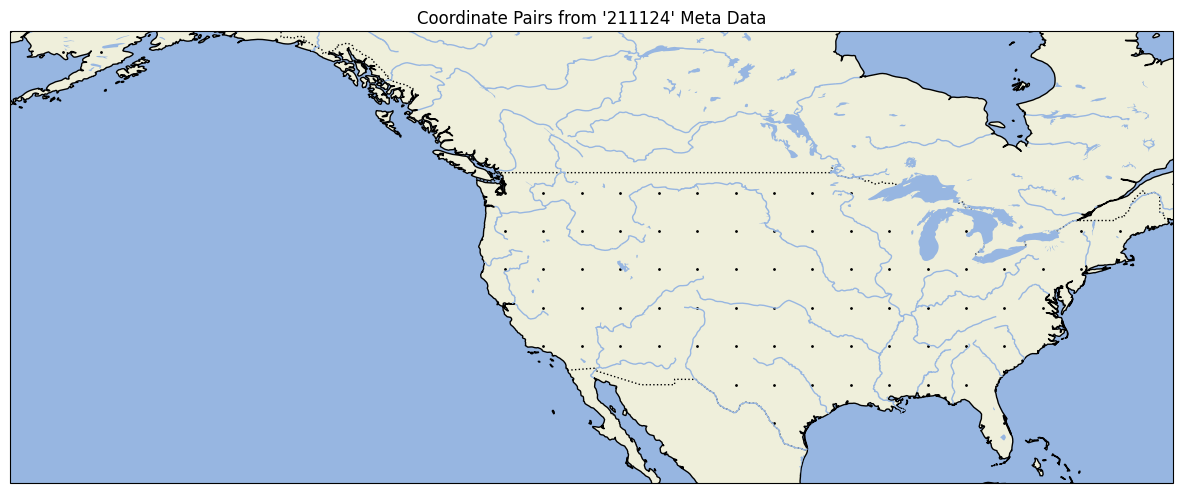

In [4]:
locationGetter.plot_coords()

In [5]:
geo_weather, geo_meta = locationGetter.geospatial_data()

geo_meta = geo_meta[geo_meta['state'] != "Alaska"]
geo_weather = geo_weather.sel(gid=geo_meta.index)

In [6]:
shapes = {
    "annual_poa" : ("gid",),
    "ground_irradiance" : ("gid", "time", "distance")
}

template = pvdeg.geospatial.output_template(
    ds_gids = geo_weather,
    shapes = shapes,
    add_dims={"distance" : 10}, # this will autogenerate a range of length 10 for the coordinate axis
)

In [7]:
pysam_tiny_res = pvdeg.geospatial.analysis(
    weather_ds = geo_weather,
    meta_df = geo_meta,
    func = pvdeg.pysam.inspire_ground_irradiance, 
    template = template,
    config_files = {"pv" : '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/01/01_pvsamv1.json'}
)

ERROR:tornado.application:Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOMainLoop object at 0x7f076249a6e0>>, <Task finished name='Task-103502' coro=<ProfileTimePlot.trigger_update.<locals>.cb() done, defined at /home/tford/.conda-envs/rpp/lib/python3.10/site-packages/distributed/utils.py:836> exception=AttributeError("'NoneType' object has no attribute 'add_next_tick_callback'")>)
Traceback (most recent call last):
  File "/home/tford/.conda-envs/rpp/lib/python3.10/site-packages/tornado/ioloop.py", line 750, in _run_callback
    ret = callback()
  File "/home/tford/.conda-envs/rpp/lib/python3.10/site-packages/tornado/ioloop.py", line 774, in _discard_future_result
    future.result()
  File "/home/tford/.conda-envs/rpp/lib/python3.10/site-packages/distributed/utils.py", line 838, in wrapper
    return await func(*args, **kwargs)
  File "/home/tford/.conda-envs/rpp/lib/python3.10/site-packages/distributed/dashboar

In [8]:
pysam_tiny_res.to_netcdf('downsample40-conf01-pysam-ground-irradiance.nc', engine='h5netcdf')

/home/tford/.conda-envs/rpp/lib/python3.10/site-packages/distributed/client.py:3245: UserWarning: Sending large graph of size 108.44 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [9]:
pysam_tiny_res

<xarray.Dataset> Size: 191MB
Dimensions:            (latitude: 8, longitude: 17, time: 17520, distance: 10)
Coordinates:
  * latitude           (latitude) float32 32B 24.85 28.13 31.33 ... 44.13 47.33
  * longitude          (longitude) float32 68B -122.3 -119.1 ... -74.34 -71.14
  * time               (time) datetime64[ns] 140kB 2022-01-01 ... 2022-12-31T...
  * distance           (distance) int64 80B 0 1 2 3 4 5 6 7 8 9
Data variables:
    annual_poa         (latitude, longitude) float64 1kB nan nan nan ... nan nan
    ground_irradiance  (time, distance, latitude, longitude) float64 191MB dask.array<chunksize=(17520, 10, 1, 17), meta=np.ndarray>

In [11]:
res = pvdeg.pysam.inspire_ground_irradiance(
    geo_weather.isel(gid=0).to_dataframe(),
    geo_meta.iloc[0].to_dict(),
    config_files = {"pv" : '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/01/01_pvsamv1.json'}
)

In [12]:
res.ground_irradiance[0][1:]

(0.2502810919746036,
 0.7508432759238107,
 1.251405459873018,
 1.751967643822225,
 2.2525298277714323,
 2.753092011720639,
 3.2536541956698466,
 3.7542163796190535,
 4.2547785635682605,
 4.755340747517468)